In [66]:
from langgraph.graph import START, StateGraph, END
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from CONFIG import GROQ_MODEL
from pydantic import Field, BaseModel
from typing import Annotated, List, TypedDict, Literal
from langgraph.types import Send
from langchain_core.messages import HumanMessage, SystemMessage
import operator

In [67]:
load_dotenv()
llm = ChatGroq(model=GROQ_MODEL)

In [68]:
class Tasks(BaseModel):
    id: int = Field(
        ...,
	  description="Unique identifier for the task (must be an integer)."
      )
    task_title: str = Field(
        ...,
	  description="A task title designed to arouse curiosity in the reader."
      )
    goal: str = Field(
        ...,
	  description="One sentence describing what the reader should be able to do or understand after this section."
      )
    bullets: List[str] = Field(
        ...,
      min_length=3,
      max_length=5,
	description="3–5 concrete, non-overlapping subpoints to cover in this section."
    )
    target_words: int = Field(
        ...,
	  description="Target word count for this section (120–450)."
      )
    section_type: Literal[
        "intro", "core", "examples", "checklist", "common_mistakes", "conclusion"
      ] = Field(..., description="NOTE: Use 'common_mistakes' exactly once in the plan.")
    brief: str = Field(
        ...,
	  description='what to cover'
      )

class Plan(BaseModel):
    blog_title: str = Field(..., description="Title of the blog.")
    audience: str = Field(..., description="The intended audience for this blog.")
    tone: str = Field(..., description="The writing tone (e.g., practical, crisp).")
    tasks: List[Tasks] = Field(..., description="List of tasks to structure the blog.")

In [69]:
class state_class(TypedDict):
    topic: str
    plans: Plan
    sections: Annotated[List[str], operator.add]   
    final_blog: str

In [70]:
def orchestrator(state: state_class) -> dict:
    plan = llm.with_structured_output(Plan).invoke(
        [
            SystemMessage(content=(
                    "You are a senior technical writer and developer advocate. Your job is to produce a "
                    "highly actionable outline for a technical blog post.\n\n"
                    "Hard requirements:\n"
                    "- Create 5–7 sections (tasks) that fit a technical blog.\n"
                    "- Each section must include:\n"
                    "  1) goal (1 sentence: what the reader can do/understand after the section)\n"
                    "  2) 3–5 bullets that are concrete, specific, and non-overlapping\n"
                    "  3) target word count (120–450)\n"
                    "- Include EXACTLY ONE section with section_type='common_mistakes'.\n\n"
                    "Make it technical (not generic):\n"
                    "- Assume the reader is a developer; use correct terminology.\n"
                    "- Prefer design/engineering structure: problem → intuition → approach → implementation → "
                    "trade-offs → testing/observability → conclusion.\n"
                    "- Bullets must be actionable and testable (e.g., 'Show a minimal code snippet for X', "
                    "'Explain why Y fails under Z condition', 'Add a checklist for production readiness').\n"
                    "- Explicitly include at least ONE of the following somewhere in the plan (as bullets):\n"
                    "  * a minimal working example (MWE) or code sketch\n"
                    "  * edge cases / failure modes\n"
                    "  * performance/cost considerations\n"
                    "  * security/privacy considerations (if relevant)\n"
                    "  * debugging tips / observability (logs, metrics, traces)\n"
                    "- Avoid vague bullets like 'Explain X' or 'Discuss Y'. Every bullet should state what "
                    "to build/compare/measure/verify.\n\n"
                    "Ordering guidance:\n"
                    "- Start with a crisp intro and problem framing.\n"
                    "- Build core concepts before advanced details.\n"
                    "- Include one section for common mistakes and how to avoid them.\n"
                    "- End with a practical summary/checklist and next steps.\n\n"
                    "Output must strictly match the Plan schema."
                )
            ),
            HumanMessage(content=f"Topic is here:- {state['topic']}")
	  ]
    )

    return {'plans': plan}

In [71]:
def task_distributor(state: state_class):
    return [Send(
        'worker', {
            'task': task,
            'topic': state['topic'],
            'plan': state['plans']
	  }
    ) for task in state['plans'].tasks]

In [72]:
def worker(payload: dict):
    task = payload['task']
    topic = payload['topic']
    plan = payload['plan']
    blog_title = plan.blog_title

    create_sections = llm.invoke(
        [
            SystemMessage(content=(
        "You are a senior technical writer and developer advocate. Write ONE section of a technical blog post in Markdown.\n\n"
        "Hard constraints:\n"
        "- Follow the provided Goal and cover ALL Bullets in order (do not skip or merge bullets).\n"
        "- Stay close to the Target words (±15%).\n"
        "- Output ONLY the section content in Markdown (no blog title H1, no extra commentary).\n\n"
        "Technical quality bar:\n"
        "- Be precise and implementation-oriented (developers should be able to apply it).\n"
        "- Prefer concrete details over abstractions: APIs, data structures, protocols, and exact terms.\n"
        "- When relevant, include at least one of:\n"
        "  * a small code snippet (minimal, correct, and idiomatic)\n"
        "  * a tiny example input/output\n"
        "  * a checklist of steps\n"
        "  * a diagram described in text (e.g., 'Flow: A -> B -> C')\n"
        "- Explain trade-offs briefly (performance, cost, complexity, reliability).\n"
        "- Call out edge cases / failure modes and what to do about them.\n"
        "- If you mention a best practice, add the 'why' in one sentence.\n\n"
        "Markdown style:\n"
        "- Start with a '## <Section Title>' heading.\n"
        "- Use short paragraphs, bullet lists where helpful, and code fences for code.\n"
        "- Avoid fluff. Avoid marketing language.\n"
        "- If you include code, keep it focused on the bullet being addressed.\n"
    )
    ),
            HumanMessage(content=(
                f"Blog: {blog_title}\n"
                f"Topic: {topic}\n"
                f"Task Title: {task.task_title}\n"
                f"Audience: {plan.audience}\n"
                f"Tone: {plan.tone}\n"
                f"Goal: {task.goal}\n"
                f"Bullets: {task.bullets}\n"
                f"Target Words: {task.target_words}\n"
                f"Section Type: {task.section_type}\n"
                f"Brief: {task.brief}\n"
                "Return only the section content in Markdown style."
            ))
        ]
    ).content.strip()

    return {'sections': [create_sections]}

In [73]:
from pathlib import Path

def reducer(state: state_class):
    title = state['plans'].blog_title
    body = '\n\n'.join(state['sections']).strip()

    if not body:
        raise ValueError("No content to write. Ensure 'sections' is not empty.")

    # Sanitize filename
    filename = ''.join(c if c.isalnum() or c in (' ', '_', '-') else '' for c in title)
    filename = filename.strip().lower().replace(' ', '_') + ".md"

    # Include the blog title in the final markdown content
    final_md = f"# {title}\n\n{body}"

    output_path = Path(filename)
    output_path.write_text(final_md, encoding='utf-8')

    return {'final_blog': final_md}

In [74]:
g = StateGraph(state_class)

g.add_node('orchestrator', orchestrator)
g.add_node('worker', worker)
g.add_node('reducer', reducer)

g.add_edge(START, 'orchestrator')
g.add_conditional_edges('orchestrator', task_distributor, ['worker'])
g.add_edge('worker', 'reducer')
g.add_edge('reducer', END)

graph = g.compile()

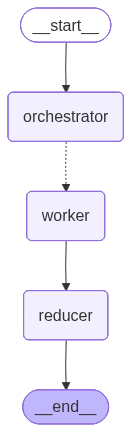

In [75]:
graph

In [76]:
output = graph.invoke({'topic': 'AI Agents vs Agentic AI', 'sections': []})

In [77]:
output

{'topic': 'AI Agents vs Agentic AI',
 'plans': Plan(blog_title='AI Agents vs Agentic AI: Understanding the Difference', audience='developers', tone='technical', tasks=[Tasks(id=1, task_title='Introduction to AI Agents and Agentic AI', goal='The reader can understand the basic concepts of AI agents and agentic AI', bullets=['Define AI agents and their applications', 'Explain the concept of agentic AI and its relationship to AI agents', 'Show a simple diagram illustrating the difference between AI agents and agentic AI'], target_words=200, section_type='intro', brief='Introduction to AI agents and agentic AI'), Tasks(id=2, task_title='Core Concepts of AI Agents', goal='The reader can design a basic AI agent', bullets=['Explain the components of an AI agent (perception, reasoning, action)', 'Show a minimal working example (MWE) of an AI agent in Python', 'Discuss the importance of feedback loops in AI agent design'], target_words=300, section_type='core', brief='Core concepts of AI agents